**Task**: It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

**Evaluation**: Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

This notebook has been created after studying [this notebook.](https://www.kaggle.com/ankitverma2010/house-prices-prediction-beginner-to-advanced#Exploratory-Data-Analysis)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Import libraries

In [2]:
# Python imports
import os

# Maths and data imports
import numpy as np
import pandas as pd

# Plot imports
import seaborn as sns
import matplotlib.pyplot as plt

# ML modeling imports
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBRegressor

In [ ]:
%matplotlib inline
sns.set()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
myfile = files.upload()

Saving train.csv to train.csv


In [3]:
# Dataset is now stored in a Pandas Dataframe
url = 'https://raw.githubusercontent.com/bhjo0930/kaggle_house_price/main/train.csv'
originTrain = pd.read_csv(url,index_col='Id')
url = 'https://raw.githubusercontent.com/bhjo0930/kaggle_house_price/main/test.csv'
originTest = pd.read_csv(url,index_col='Id')
#train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
#test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')


In [5]:
train_df = originTrain.copy()
test_df = originTest.copy()

## Data Preprocessing

In [ ]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train_df.shape

(1460, 80)

In [ ]:
train_df.info()

In [6]:
# MSSubClass, OverallQual and OverallCond and categorical variable, lets convert it into one.
train_df['MSSubClass'] = train_df['MSSubClass'].astype('object')
train_df['OverallQual'] = train_df['OverallQual'].astype('object')
train_df['OverallCond'] = train_df['OverallCond'].astype('object')

test_df['MSSubClass'] = test_df['MSSubClass'].astype('object')
test_df['OverallQual'] = test_df['OverallQual'].astype('object')
test_df['OverallCond'] = test_df['OverallCond'].astype('object')

Let's now seperate the categorical and numerical columns

In [7]:
def get_var_dtype_list(df):
    cat_cols = []
    num_cols = []

    for col in df.columns:
        if df[col].dtypes == 'object':
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return (cat_cols, num_cols)

In [8]:
cat_cols_train, num_cols_train = get_var_dtype_list(train_df)

In [9]:
cat_cols_test, num_cols_test = get_var_dtype_list(test_df)

Let's take log of SalePrice as our evaluation metric is log RMS value.

In [10]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])

## EDA

In EDA we will analyse data to see if there is any - 
1. Skewness in features
2. Check for missing values and ouliers and fix them.
3. Check the variability of different features and scale them.
4. Check for multicolinearity among multiple exploratory variables (features).
5. Check if response variable is correlated to any/may exploratory variable(s).
6. Analyse the target/response variable.

### Lets check distribution fo continuous columns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

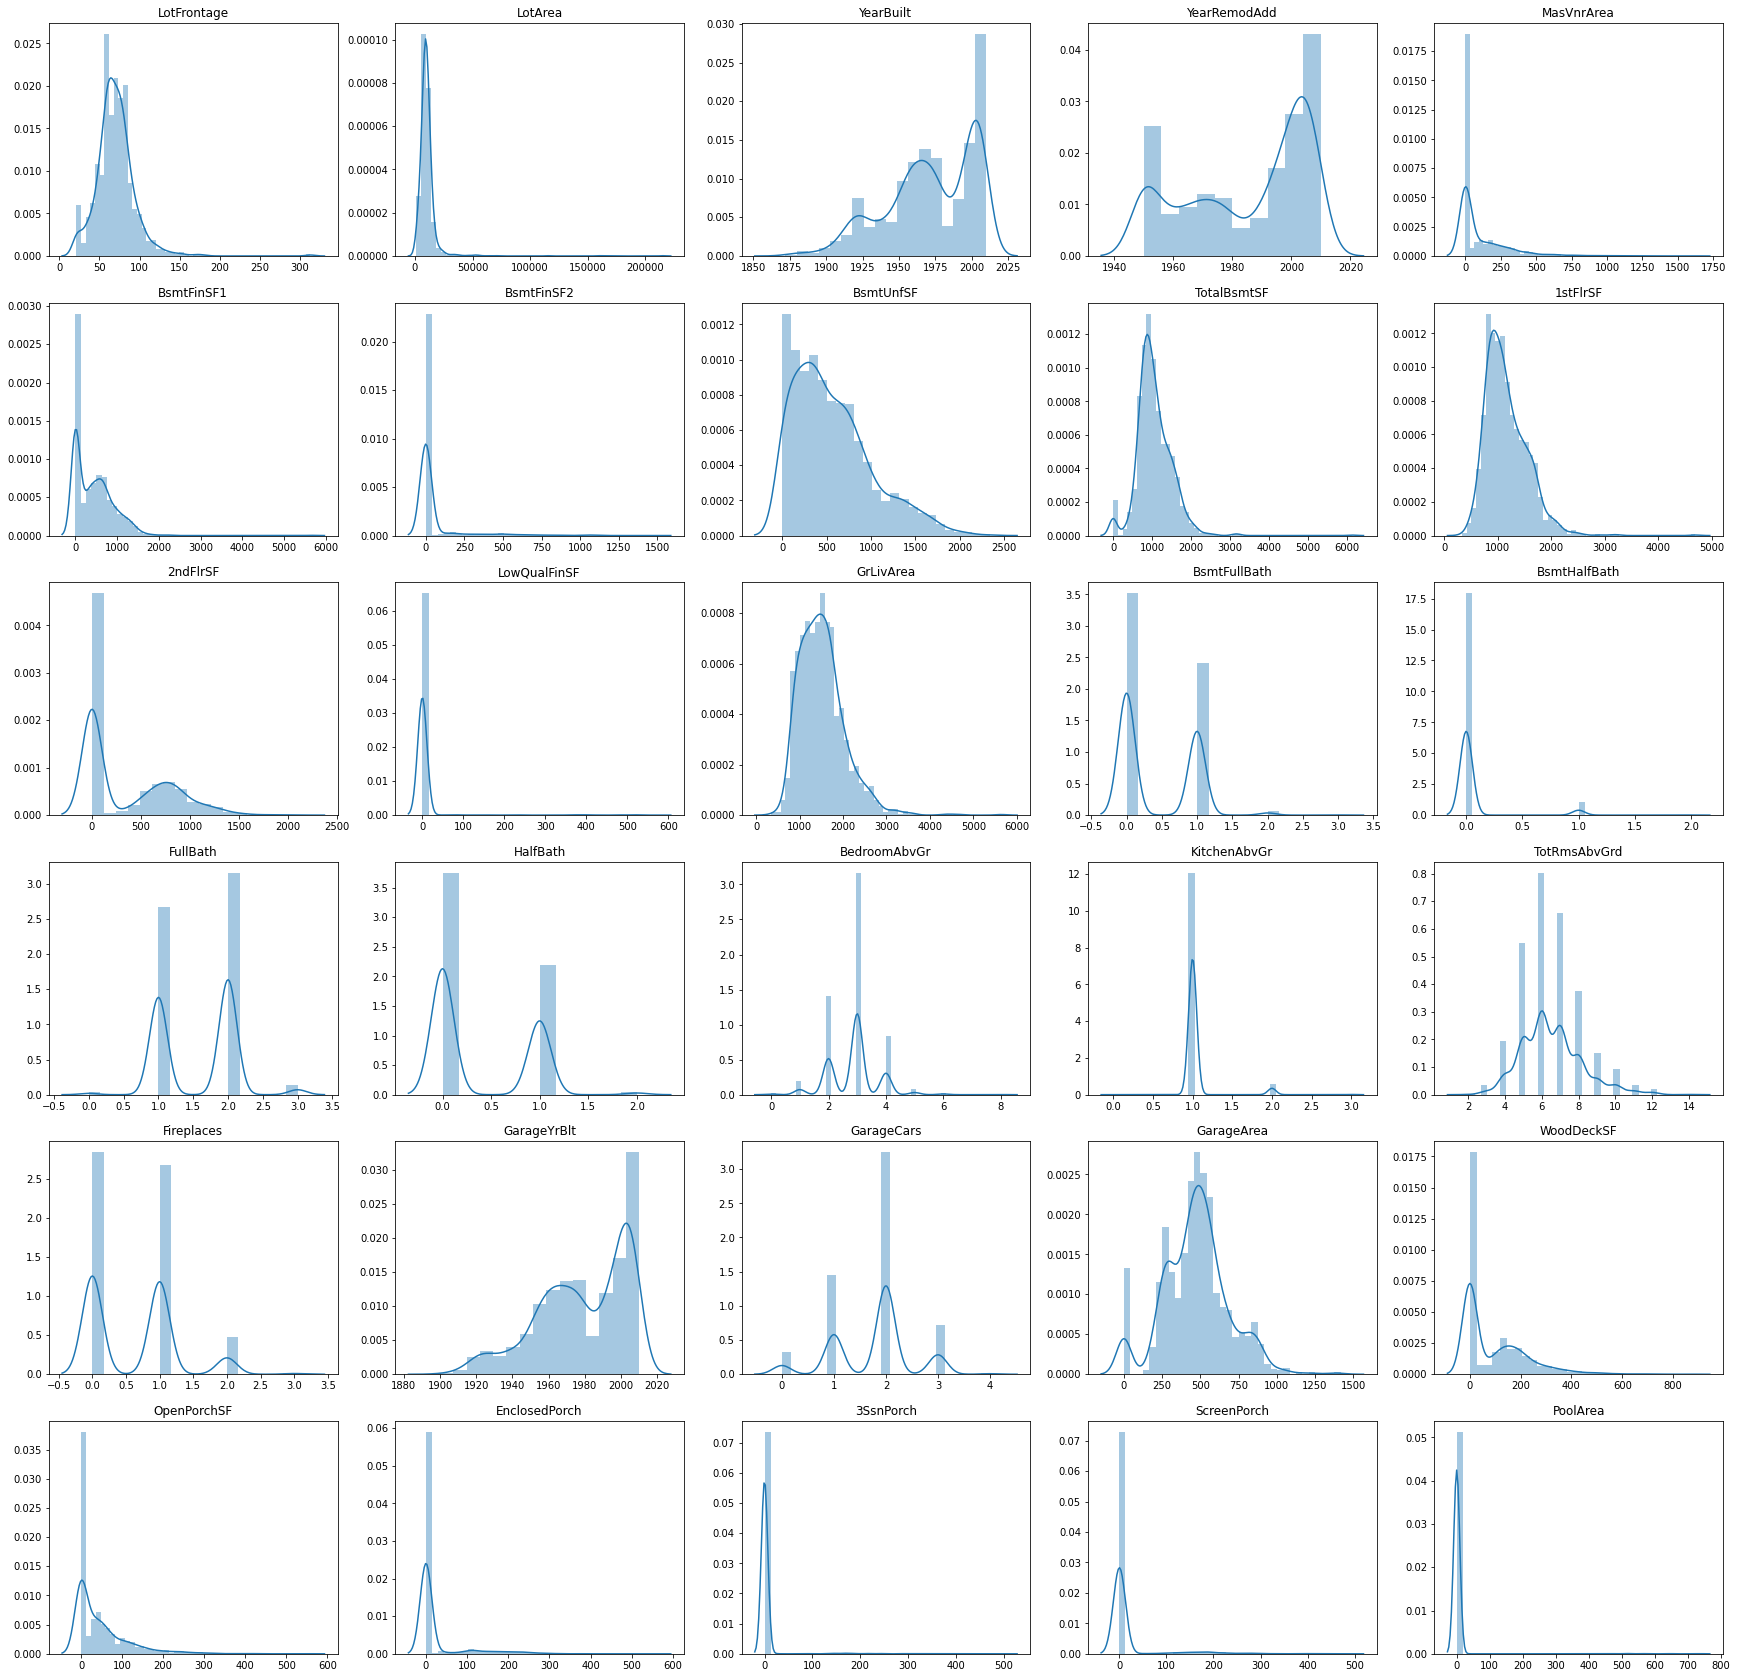

In [11]:
fig, axs = plt.subplots(len(num_cols_train)//5, 5, figsize=(30, 30))
for col, ax in zip(num_cols_train[:-1], axs.flatten()):
    sns.displot(train_df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.show()

**Conclusion**

1. There is  large variation in the scale of each continuous variables, hence, we need to scale them.
2. Features such as YearBuilt and GarageYrBlt are left skewed, indicating that more houses were build in the later years hence, more garages were also built then. So, we might want to leave such variable for outlier check.
3. Exploratory varibales - 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtHalfBath', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal' are heavily right skewed.

Let's further explore these variables.

In [12]:
right_skewed = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                'LowQualFinSF', 'BsmtHalfBath', 'WoodDeckSF', 'OpenPorchSF', 
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

In [21]:
r_skew_desc = train_df[right_skewed].describe().T # Transpose
r_skew_desc['coef_of_var'] = r_skew_desc['std']/r_skew_desc['mean']

r_skew_desc

,count,mean,std,min,25%,50%,75%,max,coef_of_var
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.50,215245.0,0.949076
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.0,0.0,166.00,1600.0,1.746306
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.0,383.5,712.25,5644.0,1.028082
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.0,0.0,0.00,1474.0,3.465556
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.0,477.5,808.00,2336.0,0.778977
LowQualFinSF,1460.0,5.844521,48.623081,0.0,0.0,0.0,0.00,572.0,8.319430
BsmtHalfBath,1460.0,0.057534,0.238753,0.0,0.0,0.0,0.00,2.0,4.149748
WoodDeckSF,1460.0,94.244521,125.338794,0.0,0.0,0.0,168.00,857.0,1.329932
OpenPorchSF,1460.0,46.660274,66.256028,0.0,0.0,25.0,68.00,547.0,1.419967
EnclosedPorch,1460.0,21.954110,61.119149,0.0,0.0,0.0,0.00,552.0,2.783950


We can see a huge variation in lot of features. For now we can drop the columns with coefficient of variation > 3.

As the number of missing values is zero or near to zero in most of the features we would like to further analyse them (maybe take log to reduce the right skewness) and embrace the variability.

But for now lets got with dropping them off, and compare the effects in the next iteration/followup.

In [ ]:
r_skew_desc[r_skew_desc['coef_of_var']>3].T.columns

In [ ]:
drop_skew_cols = ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch',
                  'ScreenPorch', 'PoolArea', 'MiscVal']

train_df.drop(drop_skew_cols, axis=1, inplace=True)
test_df.drop(drop_skew_cols, axis=1, inplace=True)

In [ ]:
train_df.columns

Let's update out list of numerical columns list.

In [ ]:
cat_cols_train, num_cols_train = get_var_dtype_list(train_df)
cat_cols_test, num_cols_test = get_var_dtype_list(test_df)

### Let check and impute missing values in continuous variables

In [ ]:
def get_missing_stats(df, col_list, threshold=0):
    total = len(df)
    for col in col_list:
        null = df[col].isnull().sum()
        if null > 0 and null/total >= threshold:
            print(col)
            if df[col].dtypes == 'object':
                print(df[col].value_counts())
            print(f'Missing values: {null} of {total}')
            print(f'Percent missing values: {round((null*100)/total, 2)}%\n')

In [ ]:
get_missing_stats(train_df, num_cols_train)

In [ ]:
get_missing_stats(test_df, num_cols_test)

It does not seem to be extreme case of missing values so, we can simply replace by the median (as the data seem to be highly variable and median is a robust metric) of training set in both the training and test set.

In [ ]:
imputer = SimpleImputer(strategy='median')
train_df[num_cols_train[:-1]] = imputer.fit_transform(train_df[num_cols_train[:-1]])
test_df[num_cols_test] = imputer.transform(test_df[num_cols_test])

In [ ]:
get_missing_stats(train_df, num_cols_train)

In [ ]:
get_missing_stats(test_df, num_cols_test)

So, the missing values for numerical columns have disappeared. Now, lets hit the categorical columns.

### Now, lets check and impute missing values of categorical columns.

In [ ]:
get_missing_stats(train_df, cat_cols_train)

In [ ]:
get_missing_stats(test_df, cat_cols_test)

Some columns seet to have quite a number of missing values. Lets further analyse them using barplot.

In [ ]:
fig, axs = plt.subplots(len(cat_cols_train)//5, 5, figsize=(30, 40))
for col, ax in zip(cat_cols_train, axs.flatten()):
    y = train_df[col].value_counts()
    ax.bar(y.index, y.values)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(35)
plt.show()

Let's just analyse the columns with missing frequency greater than 40%.

In [ ]:
get_missing_stats(train_df, cat_cols_train, 0.4)

In [ ]:
get_missing_stats(test_df, cat_cols_test, 0.4)

We can infer two cases from above:
1. The houses did not have these features
2. The houses did have these features but were not reported.

However, if we think then it seems feasible to assume that all the houses surveyed did not have all the 80 features. So, for now we can impute the missing values (with freq. > 40%) with N.A, where as missing values of columns with freq < 40% with most frequent value.

I think it will be safe to assume and hypothesise that maybe the localities in which the houses were surveyed did not have the above features, thus introducing selective bias in data collection. Although, we can not be certain of it.

In [ ]:
train_df.drop(['PoolQC'], axis=1, inplace=True)
test_df.drop(['PoolQC'], axis=1, inplace=True)

In [ ]:
na_cols = ['Alley','FireplaceQu','Fence','MiscFeature']

na_imputer = SimpleImputer(strategy='constant', fill_value='N.A')
train_df[na_cols] = na_imputer.fit_transform(train_df[na_cols])
test_df[na_cols] = na_imputer.transform(test_df[na_cols])

In [ ]:
cat_cols_train, num_cols_train = get_var_dtype_list(train_df)
cat_cols_test, num_cols_test = get_var_dtype_list(test_df)

In [ ]:
mf_imputer = SimpleImputer(strategy='most_frequent')
train_df[cat_cols_train] = mf_imputer.fit_transform(train_df[cat_cols_train])
test_df[cat_cols_test] = mf_imputer.transform(test_df[cat_cols_test])

In [ ]:
get_missing_stats(train_df, cat_cols_train)

In [ ]:
get_missing_stats(test_df, cat_cols_test)

Finally, we have dealt with missing values. Now, lets check for multicolinearity among exploratory variables.

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.drop(['SalePrice'], axis=1).corr(), annot=True)
plt.show()

In [ ]:
cor = train_df.drop(['SalePrice'], axis=1).corr()
for i, col in enumerate(cor.columns):
    for row in cor.index[i+1:]:
        if col != row and cor[col][row] > 0.7:
            print(f'({row}, {col}): {cor[col][row]}')

Hmm...From the overwhelming plots above we can see that few varibles are highly correlated, and it makes sense for them to be correlated. Hence, for now we might want to keep them.

### Scale variables

In [ ]:
scaler = StandardScaler()
train_df[num_cols_train[:-1]] = scaler.fit_transform(train_df[num_cols_train[:-1]])
test_df[num_cols_test] = scaler.transform(test_df[num_cols_test])

### One-hot encoding of categorical columns

For now, let's simply one hot encode the categorical columns.

In [ ]:
cat_cols_train

In [ ]:
cat_cols_train, num_cols_train = get_var_dtype_list(train_df)
cat_cols_test, num_cols_test = get_var_dtype_list(test_df)

In [ ]:
train_df = pd.get_dummies(train_df, drop_first=True, columns=cat_cols_train)
test_df = pd.get_dummies(test_df, drop_first=True, columns=cat_cols_test)

In [ ]:
train_df.head()

### Check train and test for compatability

In [ ]:
# check if both train and test contain same columns
train_df.columns

In [ ]:
test_df.columns

In [ ]:
compat_list = list(set(train_df.columns).intersection(test_df.columns))

In [ ]:
len(compat_list)

In [ ]:
train_X, y = train_df[compat_list], train_df['SalePrice']
test_X = test_df[compat_list]

In [ ]:
(train_X.columns == test_X.columns).sum()

## Train Test split

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(train_X, y, test_size=0.2, random_state=42)

## Model

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(train_x, train_y)
preds = linear_regressor.predict(valid_x)
mse(valid_y, preds, squared=False)

In [ ]:
models = {
    'RFR': RandomForestRegressor,
    'ADR': AdaBoostRegressor,
    'XGB': XGBRegressor
}

In [ ]:
def fit_model(name, model, train_ds, valid_ds):
    X, y = train_ds
    X_val, y_val = valid_ds
    
    model.fit(X, y)
    y_hat = model.predict(X)
    y_hat_val = model.predict(X_val)
    
    mse_ = mse(y, y_hat, squared=False)
    mse_val = mse(y_val, y_hat_val, squared=False)
    
    print(f'Model: {name}, Train MSE: {mse_}, Val MSE: {mse_val}')

In [ ]:
n_est = [10, 25, 50, 100, 125]
for i in range(len(n_est)):
    print(f'n_estimators: {n_est[i]}')
    for name, model in models.items():
        model = model(n_estimators=n_est[i])
        fit_model(name, model, (train_x, train_y), (valid_x, valid_y))
    print('-'*20)

`n_estimators=25` seems like a sweet spot for `AdaBoostRegressor` and `XGBRegressor`. Lets ensemble te ensembles

In [ ]:
abr = AdaBoostRegressor(n_estimators=25)
xgr = XGBRegressor(n_estimators=25)

abr.fit(train_x, train_y)
xgr.fit(train_x, train_y)

p1 = abr.predict(valid_x)
p2 = xgr.predict(valid_x)
p3 = linear_regressor.predict(valid_x)

m1 = mse(valid_y, p1, squared=False)
m2 = mse(valid_y, p2, squared=False)
m3 = mse(valid_y, p3, squared=False)
m4 = mse(valid_y, (p1+p2)/2, squared=False)
m5 = mse(valid_y, (p1+p2+p3)/3, squared=False)

print(f'Ensemble MSE: \nABR: {m1}\nXGR: {m2}\nLinear: {m3}\nABR+XGR: {m4}\nABR+XGR+Linear: {m5}')

Let's try them all, 
* linear regressor
* Ensemble of AdaBoost and XGBoost
* Ensemble of all of the above

In [ ]:
pred_1 = linear_regressor.predict(test_X)
pred_2 = (abr.predict(test_X) + xgr.predict(test_X))/2
pred_3 = (2*pred_2 + pred_1)/3

In [ ]:
def create_submission(preds, name='submission.csv'):
    preds = np.expm1(preds)
    submission = pd.DataFrame({'Id': test_X.index, 'SalePrice': preds})
    submission.to_csv(name, index=False)
    return submission

In [ ]:
create_submission(pred_1, 'submission1.csv')

In [ ]:
create_submission(pred_2, 'submission2.csv')

In [ ]:
create_submission(pred_3, 'submission3.csv')

## References:

https://www.kaggle.com/ankitverma2010/house-prices-prediction-beginner-to-advanced#Exploratory-Data-Analysis

In [1]:
!pip install h2o

     |████████████████████████████████| 164.6MB 96kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.4-py2.py3-none-any.whl size=164670979 sha256=09c0f30d0af2a9e37d12c6a2feef32262d43e7ea0094fde25b6d9a1ef5ff376a
  Stored in directory: /root/.cache/pip/wheels/65/f4/0d/c9bb958d70c2e015c968cb91cbd7f1b486933056d422337d75
Successfully built h2o
